In [25]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier, LinearRegression
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
import numpy as np

puncs = '？“”！。，'

In [16]:
def read_data(dir='../data/csv/'):
    dfs = []
    for fname in ['train.csv', 'test.csv', 'valid.csv']:
        path = os.path.join(dir, fname)
        df = pd.read_csv(path)
        df = df.sample(frac=1)
        dfs.append(df)
    return dfs

In [41]:
def get_matrices(dir='../data/csv/', keep_punc=True):
    # 读取path目录下的各个csv文件，生成tfidf矩阵后返回
    df_train, df_test, df_valid = read_data(dir=dir)
    len_train, len_test, len_valid = len(df_train), len(df_test), len(df_valid)
    cut_docs = list(df_train['cut_words']) # + list(df_test['cut_words']) + list(df_valid['cut_words'])

    print('creating tfidf matrix...')
    if keep_punc:
        tfidf_model = TfidfVectorizer(token_pattern=r"(?u)\b[\u4e00-\u9fa5]{2,}\b").fit(cut_docs)
    else:
        tfidf_model = TfidfVectorizer(token_pattern=r"(?u)\b[\u4e00-\u9fa5]{2,}\b", max_df=0.5, min_df=2e-2).fit(cut_docs)

    sparse_result = tfidf_model.transform(cut_docs)
    print('create tfidf matrix sucessfully')

    #x_train, x_test, x_valid = sparse_result[:len_train], sparse_result[len_train:len_train+len_test], sparse_result[len_train+len_test:]
    x_train, x_test, x_valid = sparse_result[:len_train], tfidf_model.transform(list(df_test['cut_words'])), tfidf_model.transform(list(df_valid['cut_words']))
    y_train, y_test, y_valid = list(df_train['label']), list(df_test['label']), list(df_valid['label'])

    return x_train, x_test, x_valid, y_train, y_test, y_valid, tfidf_model

def print_topk(vectorizer, clf, class_labels, k=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        topk = np.argsort(clf.coef_[i])[-k:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in topk[::-1])))

def eval(x_eval, y_eval, model):
    y_pre = model.predict(x_eval)
    score = confusion_matrix(y_eval, y_pre)
    print(score)

In [42]:
# 不对人名进行处理
x_train_1, x_test_1, x_valid_1, y_train_1, y_test_1, y_valid_1, tfidf_model_1 = get_matrices() 
clf_1 = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf_1.fit(x_train_1, y_train_1)

creating tfidf matrix...
create tfidf matrix sucessfully


RidgeClassifier(solver='sparse_cg', tol=0.01)

In [43]:
print_topk(tfidf_model_1, clf_1, ['金庸', '古龙', '梁羽生'], k=25) # 未过滤人名

金庸: 韦小宝 袁承志 甚么 胡斐 李文秀 段誉 萧峰 石破天 心想 狄云 地下 这般 杨过 黄蓉 郭靖 乔峰 不多时 范蠡 包不同 眼见 向来 丁典 显是 张朝唐 虚竹
古龙: 铁中棠 南宫 此刻 丁鹏 但是 卜鹰 龙布 小鱼儿 柳若松 铜驼 杨铮 孙仲玉 佩玉 立刻 郭玉霞 大笑 悲情 大路 易明 朱七七 仿佛 东郭先生 八爷 语声 麻衣
梁羽生: 说道 想道 傅青主 史若梅 龙灵 忽地 凌未风 杨云聪 卓一航 铁镜心 纳兰容若 岳鸣 张玉虎 桂华生 王照 金世遗 云紫萝 多铎 若然 石星 大约 桂仲明 陈天宇 叶凌风 韩志邦


In [33]:
x_train_2, x_test_2, x_valid_2, y_train_2, y_test_2, y_valid_2, tfidf_model_2 = get_matrices(dir='../data/csv/without_name/', keep_punc=False) 
clf_2 = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf_2.fit(x_train_2, y_train_2)


creating tfidf matrix...
create tfidf matrix sucessfully


RidgeClassifier(solver='sparse_cg', tol=0.01)

In [34]:
print_topk(tfidf_model_2, clf_2, ['金庸', '古龙', '梁羽生'], k=25) # 过滤人名

金庸: 甚么 心下 当即 心想 这般 地下 眼见 旁人 起身 倘若 见到 适才 立时 始终 便是 伸手 半点 胸口 怎地 点头 更加 不得 众人 脸上 摇头
古龙: 此刻 但是 语声 大笑 仿佛 声道 忍不住 目光 立刻 无论 究竟 方才 岂非 因为 必定 简直 像是 笑了笑 厉声 沈浪 至少 别人 瞧见 半晌 没有
梁羽生: 想道 说道 事情 刚刚 忽地 如今 本领 已是 怎的 连忙 乃是 只好 可以 之后 能够 身份 当作 感到 有点 就要 不过 急忙 这样 石星 面色


In [44]:
eval(x_test_2, y_test_2, clf_2)

[[1707   16   55]
 [  16 1862   12]
 [  71   16 1866]]


In [19]:
from sklearn.decomposition import PCA, SparsePCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_train_2.toarray())
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [21]:
#df = pd.DataFrame()
finalDf = pd.concat([principalDf, pd.DataFrame(y_train_2, columns=['target'])], axis = 1)
finalDf.head()

principal component 1  principal component 2  target
0              -0.136169              -0.062570       2
1               0.051773              -0.168363       1
2              -0.047956               0.202475       2
3              -0.187123              -0.102930       0
4              -0.048319              -0.075858       2

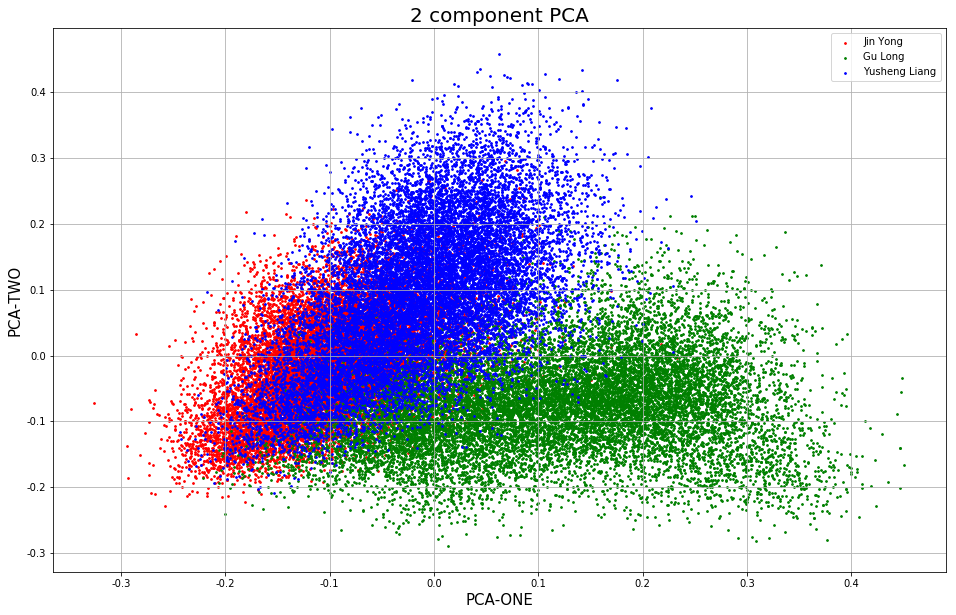

In [28]:
import matplotlib.pyplot as plt
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PCA-ONE', fontsize = 15)
ax.set_ylabel('PCA-TWO', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 3)
ax.legend(['Jin Yong', 'Gu Long', 'Yusheng Liang'])
#ax.legend(['金庸', '古龙', '梁羽生'])
ax.grid()

In [13]:
df_train = read_data('../data/csv/without_name/')[-1]

In [10]:
print(df_train['txt'][0])

张无忌大喜，正自泪眼盈盈，忍不住笑逐颜开，忙道：“哪三件事？快说，快说。”赵敏微笑道：“又哭又笑，也不怕丑！我早跟你说过，我一时想不起来，甚么时候想到了，随时会跟你说，只须你金口一诺，决不违约，那便成了。我不会要你去捉天上的月亮，不会叫你去做违背侠义之道的恶事，更不会叫你去死。自然也不会叫你去做猪做狗。”张无忌寻思：“只要不背侠义之道，那么不论多大的难题，我也当竭力以赴。”当下慨然道：“赵姑娘，倘若你惠赐灵药，治好了我俞三伯和殷六叔，但教你有所命，张无忌决不敢辞。赴汤蹈火，唯君所使。”赵敏伸出手掌，道：“好，咱们击掌为誓。我给解药于你。治好了你三师伯和六师叔之伤，日后我求你做三件事，只须不违侠义之道，你务当竭力以赴，决不推辞。”张无忌道：“谨如尊言。”和她手掌轻轻相击三下。


In [14]:
print(df_train['cut_words'][0])

大喜 ， 正自 泪眼 盈盈 ， 忍不住 笑逐颜开 ， 忙 道 ： “ 哪 三件 事 ？ 快 说 ， 快 说 。 ” 微笑 道 ： “ 又哭又笑 ， 也 不怕 丑 ！ 我 早 跟 你 说 过 ， 我 一时 想不起来 ， 甚么 时候 想到 了 ， 随时 会 跟 你 说 ， 只须 你 金口 一 诺 ， 决不 违约 ， 那 便 成 了 。 我 不会 要 你 去 捉 天上 的 月亮 ， 不会 叫 你 去 做 违背 侠义 之 道 的 恶事 ， 更 不会 叫 你 去 死 。 自然 也 不会 叫 你 去 做 猪 做 狗 。 ” ： “ 只要 不 背 侠义 之 道 ， 那么 不论 多 大 的 难题 ， 我 也 当 竭力 以 赴 。 ” 当下 慨然 道 ： “ ， 倘若 你 灵药 ， 治好 了 我 和 ， 但 教 你 有所 命 ， 决 不敢 辞 。 赴汤蹈火 ， 唯君 所使 。 ” 出 手掌 ， 道 ： “ 好 ， 咱们 击掌 为 誓 。 我 给 解药 于 你 。 治好 了 你 三 和 六 伤 ， 日后 我 求 你 做 三件 事 ， 只须 不 违 侠义 之 道 ， 你 务当 竭力 以 赴 ， 决不 推辞 。 ” 道 ： “ 谨如尊言 。 ” 和 她 手掌 轻轻 相击 三下 。
